# Parte 1: Construyendo un Sistema de recomendacion de Item-Item

Si has visto una pelicula recientemente en Netflix, recordaras la seccion que te muestra peliculas bajo el titulo "Por que viste la pelicula "x" te puede interesar:" a partir de la ultima pelicula/contenido que hayas visto en la plataforma. 

El sistema que estaremos revisando a continuacion opera bajo el mismo principio.

## Paso 1: Importar dependencias

Utilizaremos pandas para nuestro Data Frame asi como matplotlib y seaborn para visualizar los datos.

In [3]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
import html
import re

## Paso 2: Cargando los datos

Estaremos trabajando con una version reducida del dataset [MovieLens](https://grouplens.org/datasets/movielens/). 


Convertimos de json a csv

In [16]:
data = open('equipo27/ratebeer.json')

fichero = []

for line in data:
    #print(line.replace("}", "},").replace("'", '"'))
    fichero.append(line.replace("'", '"').replace("\n", "").replace("'{", "{").replace("'}", "}"))

json_data = json.dumps(fichero, indent=4)

# Save to a JSON file
with open('equipo27/data_ratebeer.json', 'w') as json_file:
    json_file.write(json_data)



'\n\nprint(fichero[:10])\n'

In [48]:
data = open('equipo27/ratebeer.json')

fichero = []

for line in data:
    #print(line.replace("}", "},").replace("'", '"'))

    if line == "":
        continue

    fichero.append('{"' + line.replace('"', "").replace("{", "").replace("}", "").replace("'Ni'", "Ni").replace("'Peng'", "Peng").replace("'Neee-wom'", "Neee-wom").replace("\n", "").replace("\t", " ").replace("': '", '": "').replace("', '", '", "').replace('&quot;', '').replace("\'", "").replace("\\", "").replace('/text: ', '/text": "') + '"}')

    #if "'}" in line[-8:]:
    #    fichero.append(line.replace('"', "").replace("\n", "").replace("\t", " ").replace("': '", '": "').replace("', '", '", "').replace("'}", '"}').replace("{'", '{"').replace('}"', '}').replace('"{', '{').replace('&quot;', '').replace("}},", '"},').replace("\'", "").replace("\\", "").replace('": {', '": "{').replace('/text: ', '/text": "').replace(".}", '"}'))
    #else:
    #    fichero.append(line.replace('"', "").replace("\n", "").replace("\t", " ").replace("': '", '": "').replace("', '", '", "').replace("\'}", '"}').replace("{'", '{"').replace('}"', '}').replace('"{', '{').replace('&quot;', '').replace("}},", '"},').replace("\'", "").replace("\\", "").replace('": {', '": "{').replace('/text: ', '/text": "').replace(".}", '"}'))

json_data = json.dumps(fichero, indent=4)

# Save to a JSON file
with open('equipo27/clean_ratebeer.json', 'w') as json_file:
    json_file.write(json_data)



In [5]:
file = open('equipo27/clean_ratebeer.json')

file_contents = file.read()

json_data = json.loads(file_contents)
#print(json_data)

cleaned_json_strings = []
for json_str in json_data:
    # Replace single backslashes before double quotes with proper escape
    json_str = re.sub(r'\\(?=")', r'\\\\', json_str)
    # Unescape HTML entities
    json_str = html.unescape(json_str)
    cleaned_json_strings.append(json_str)

# Parse JSON strings and create a list of dictionaries
data = []
for json_str in cleaned_json_strings:
    try:
        data.append(json.loads(json_str))
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print(f"Offending string: {json_str}")

#json_data = [json.loads(json_str) for json_str in data_convert]

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df[:10])


Error parsing JSON: Expecting ':' delimiter: line 1 column 4 (char 3)
Offending string: {""}
                                  beer/name beer/beerId beer/brewerId  \
0                  John Harvards Simcoe IPA       63836          8481   
1                  John Harvards Simcoe IPA       63836          8481   
2             John Harvards Cristal Pilsner       71716          8481   
3        John Harvards Fancy Lawnmower Beer       64125          8481   
4        John Harvards Fancy Lawnmower Beer       64125          8481   
5  John Harvards Vanilla Black Velvet Stout       31544          8481   
6          John Harvards American Brown Ale       71714          8481   
7                   John Harvards Grand Cru       71719          8481   
8                   John Harvards Grand Cru       71719          8481   
9                   John Harvards Grand Cru       71719          8481   

  beer/ABV            beer/style review/appearance review/aroma review/palate  \
0      5.4  India Pale

In [6]:
beers = df
beers.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [16]:
# Definimos una función para convertir "x/y" en un número flotante
def convert_to_float(fraction):
    num, denom = fraction.split('/')
    return float(num) / float(denom)

In [17]:
# Aplicamos la función a las columnas relevantes y añadimos nuevas columnas al DataFrame
beers['review/appearance_value'] = df['review/appearance'].apply(convert_to_float)
beers['review/aroma_value'] = df['review/aroma'].apply(convert_to_float)
beers['review/palate_value'] = df['review/palate'].apply(convert_to_float)
beers['review/taste_value'] = df['review/taste'].apply(convert_to_float)
beers['review/overall_value'] = df['review/overall'].apply(convert_to_float)

In [18]:
beers.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.8,0.6,0.6,0.6,0.65
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,0.8,0.6,0.8,0.7,0.65
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev...",0.8,0.5,0.6,0.6,0.70
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,0.4,0.4,0.4,0.4,0.40
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.4,0.4,0.4,0.4,0.40


## Paso 3: Analisis Exploratorio

Nos familiarizaremos con el subconjunto de datos ratings. Revisaremos cuantos ratings existen, usuarios unicos y peliculas unicas.

In [19]:
n_ratings = len(beers)
n_cervezas = beers['beer/beerId'].nunique()
n_usuarios = beers['review/profileName'].nunique()
n_cerveceras = beers['beer/brewerId'].nunique()

print(f"Total de ratings: {n_ratings}")
print(f"Total unicos de cervezas: {n_cervezas}")
print(f"Total unicos de cerveceras: {n_cerveceras}")
print(f"Total de usuarios unicos: {n_usuarios}")
print(f"Promedio de ratings por usuario: {round(n_ratings/n_usuarios, 2)}")
print(f"Promedio de ratings por cerveza: {round(n_ratings/n_cervezas, 2)}")
print(f"Promedio de ratings por cervecera: {round(n_ratings/n_cerveceras, 2)}")

Total de ratings: 2924163
Total unicos de cervezas: 110369
Total unicos de cerveceras: 7547
Total de usuarios unicos: 29265
Promedio de ratings por usuario: 99.92
Promedio de ratings por cerveza: 26.49
Promedio de ratings por cervecera: 387.46


Analicemos el total de ratings de los usuarios. Utilizaremos `count()` y `groupby()` de pandas al agrupar los datos a partir de los ids de usuarios y contabilizar el numero de ratings.

In [20]:
user_freq = beers[['review/profileName', 'beer/beerId']].groupby('review/profileName').count().reset_index()
user_freq.columns = ['review/profileName', 'n_ratings']
user_freq.head()

,review/profileName,n_ratings
0,-BB-99,2
1,000pete1983,1
2,007BeerDrinker,1
3,007Lager,1
4,007lund,86


In [22]:
print(f"Numero de ratings por usuario: {user_freq['n_ratings'].mean():.2f}.")

Numero de ratings por usuario: 99.92.


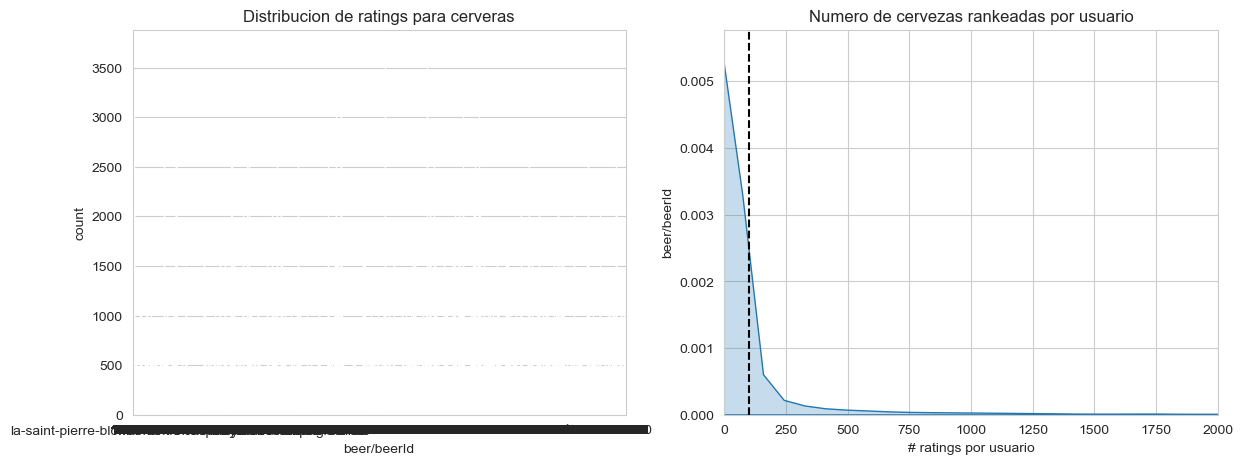

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="beer/beerId", data=beers, palette="rocket")
plt.title("Distribucion de ratings para cerveceras")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlim(0, 2000)
plt.xlabel("# ratings por usuario")
plt.ylabel("beer/beerId")
plt.title("Numero de cervezas rankeadas por usuario")
plt.show()

### Si deseamos conocer cual es la cerveza con el rating promedio mas bajo y cual es la que tiene el ranting mas alto?

In [23]:
rating_media = beers.groupby('beer/beerId')[['review/overall_value']].mean()
print(f"Cerveza con el rating mas bajo")
rating_bajo = rating_media['review/overall_value'].idxmin()
beers.loc[beers['beer/beerId'] == rating_bajo]


Cerveza con el rating mas bajo


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value
2613550,Pups Monadnock Harvest Hard Cider,100425,10296,8,Cider,4/5,1/10,1/5,1/10,1/20,1278547200,mdesq,I purchased a bottle of Pups cider from my loc...,0.8,0.1,0.2,0.1,0.05


In [25]:
rating_alto = rating_media['review/overall_value'].idxmax()
print(f"Cerveza con el rating mas alto")
beers.loc[beers['beer/beerId'] == rating_alto]

Cerveza con el rating mas alto


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value
1562838,Bullfrog Apricot Wheat (Kegs Gone Wild),101673,539,5,Wheat Ale,5/5,9/10,5/5,9/10,20/20,1238889600,soto,Simply amazing taste. Very fruity. Pours with ...,1.0,0.9,1.0,0.9,1.0


Analicemos la cantidad de ratings que tiene la mejor cerveza.

In [26]:
beers[beers['beer/beerId']==rating_alto]

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value
1562838,Bullfrog Apricot Wheat (Kegs Gone Wild),101673,539,5,Wheat Ale,5/5,9/10,5/5,9/10,20/20,1238889600,soto,Simply amazing taste. Very fruity. Pours with ...,1.0,0.9,1.0,0.9,1.0


Revisando los ratings, Lamerica solo tiene 2 calificaciones. 
Por lo tanto, la mejor manera de evaluar la popularidad de una pelicula es utilizando Promedios Bayesianos.

## Promedio Bayesiano

Se define de la siguiente manera:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

Donde $C$ representa la confianza, $m$ representa el promedio aritmetico, y $N$ es el numero total de "reviews" de una pelicula $i$. En este caso, $m$ correspondera al promedio de ratings considerando todas las peliculas. Por definicion, C representa "el tamano tipico del dataset". Por lo tanto $C$ sera el el promedio de ratings para una pelicula determinada.

In [30]:
beers_stats = beers.groupby('beer/beerId')[['review/overall_value']].agg(['count', 'mean'])
beers_stats.columns = beers_stats.columns.droplevel()

In [31]:
C = beers_stats['count'].mean()
m = beers_stats['mean'].mean()

def promedio_bayesiano(ratings):
    promedio_bayesiano = (C*m+ratings.sum())/(C+ratings.count())
    return promedio_bayesiano

ratings_promedio_bayesiano = beers.groupby('beer/beerId')['review/overall_value'].agg(promedio_bayesiano).reset_index()
ratings_promedio_bayesiano.columns = ['beer/beerId', 'promedio_bayesiano']
beers_stats = beers_stats.merge(ratings_promedio_bayesiano, on='beer/beerId')

In [32]:
beers_stats = beers_stats.merge(beers[['beer/beerId', 'beer/name']])
beers_stats.sort_values('promedio_bayesiano', ascending=False).head()

,beer/beerId,count,mean,promedio_bayesiano,beer/name
1730528,4934,2060,0.911311,0.907745,Westvleteren 12
1729129,4934,2060,0.911311,0.907745,Westvleteren 12
1729163,4934,2060,0.911311,0.907745,Westvleteren 12
1729164,4934,2060,0.911311,0.907745,Westvleteren 12
1729165,4934,2060,0.911311,0.907745,Westvleteren 12


Al utilizar el Promedio Bayesiano podemos notar que la cerveza `Westvleteren 12` es la cerveza con el rating mas alto. 


Cual es ahora la cerveza con el peor rating segun los Promedios Bayesianos?

In [33]:
beers_stats.sort_values('promedio_bayesiano', ascending=True).head()

,beer/beerId,count,mean,promedio_bayesiano,beer/name
1885816,5530,411,0.147689,0.176929,ODouls
1885745,5530,411,0.147689,0.176929,ODouls
1885746,5530,411,0.147689,0.176929,ODouls
1885747,5530,411,0.147689,0.176929,ODouls
1885748,5530,411,0.147689,0.176929,ODouls


Al utilizar Promedios Bayesianos de nuevo, la cerveza `ODouls` es la que tiene el peor rating por lo que la cerveza `Pups Monadnock Harvest Hard Cider` no es en realidad la peor (como se creia en pasos anteriores).

## Paso 4: Transformando los datos

Se utilizara una tecnica denominada [filtrado colaborativo](https://en.wikipedia.org/wiki/Collaborative_filtering) para generar recomendaciones para el usuario. Esta tecnica parte de la suposicion de homogeneidad en los datos (usuarios similares les interesan las mismas cosas). El filtrado colaborativo es un tipo de aprendizaje no supervisado que realiza predicciones acerca de los intereses de un usuario al aprender de los intereses de una poblacion de gran tamaño.

El primer paso del filtrado colaborativo consiste en transformar nuestros datos en una `matriz usuario-item (user-item matrix)`. En dicha matriz, las filas representan a los usuarios y las columnas representan a los items. El filtrado colaborativo no requiere de informacion sobre los usuarios o los items para generar las recomendaciones.


<img src="imagenes/user-movie-matrix.png" width="500px" align="left">

La funcion `create_X()` crea una matriz dispersa X a partir de 4 diccionarios de mapeo principales

- **mapeo_usuario:** mapea el ID usuario al indice del usuario
- **mapeo_pelicula:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

Requerimos de estos diccionarios porque mapean la fila y columna de la matriz de utilidad corresponden que ID de usuario e ID de película, respectivamente.

La matriz **X** (user-item) matrix es una matriz [scipy.sparse.csr_matrix](scipylinkhere) que almacena los datos de manera disperas.

In [34]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del dataframe de ratings
    
    Argumentos:
        df: dataframe en pandas
    
    Regresa:
        X: matriz dispersa
        mapeo_usuario: dict que mapea el id del usuario con los indices del usuario
        mapeo_inverso_usuario: dict que mapea los indices del usuario con los id's del usuario
        mapeo_pelicula: dict que mapea los id's de las peliculas con los indices de las peliculas
        mapeo_inverso_pelicula: dict que mapea los indices de las peliculas con los id's de las peliculas
    """
    N = df['review/profileName'].nunique()
    M = df['beer/beerId'].nunique()

    mapeo_usuario = dict(zip(np.unique(df["review/profileName"]), list(range(N))))
    mapeo_pelicula = dict(zip(np.unique(df["beer/beerId"]), list(range(M))))
    
    mapeo_inverso_usuario = dict(zip(list(range(N)), np.unique(df["review/profileName"])))
    mapeo_inverso_pelicula = dict(zip(list(range(M)), np.unique(df["beer/beerId"])))
    
    user_index = [mapeo_usuario[i] for i in df['review/profileName']]
    movie_index = [mapeo_pelicula[i] for i in df['beer/beerId']]

    X = csr_matrix((df["review/overall_value"], (movie_index, user_index)), shape=(M, N))
    
    return X, mapeo_usuario, mapeo_pelicula, mapeo_inverso_usuario, mapeo_inverso_pelicula

In [38]:
X, user_mapper, beer_mapper, user_inv_mapper, beer_inv_mapper = create_X(beers)

Podremos calcular la dispersion de nuestra matriz X al dividir el total de elementos no ceros por el total de elementos.

In [39]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,2)}%")

Dispersion de la Matriz: 0.09%


Esto nos indica que solo el 1.7% de las celdas de la matriz usuario-item tienen ratings. Regularmente esto sucede en este tipo de matrices y como regla general la dispersion no debe ser menor a 0.5% para obtener resultados aceptables.

### Guardando la matriz a un archivo

Guardaremos la matriz usuario-item para el siguiente paso. Dado que nuestra matriz esta representada como una matriz dispersa scipy (scipy sparse matrix),utilizaremos el metodo [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) para guardar nuestra matriz como archivo.

In [40]:
from scipy.sparse import save_npz

save_npz('equipo27/matriz_usuario_item.npz', X)



## Paso 5: Hallando cervezas parecidas utilizando KNN (k-Nearest Neighbours)

Al utilizar esta estrategia, podemos hallar los $k$ vecinos de una pelicula determinada al identificar los $k$ puntos en el dataset que estan mas cercanos a la pelicula $m$. kNN hace uso de metricas de distancias tales como:

1. Similaridad Coseno (Cosine similarity)
2. Distancia Euclidiana (Euclidean distance)
3. Distancia Manhattan (Manhattan distance)
4. Correlacion de Pearson (Pearson correlation )

Es un tanto cuanto dificil de visualizar, pero estamos trabajando en un espacio multidimensional M (donde M representa el numero de peliculas en nuestra matriz X)


In [41]:
from sklearn.neighbors import NearestNeighbors

def encuentra_cervezas_parecidas(beer_id, X, k, metric='cosine', show_distance=False):
    """
    Encuentra los k-vecinos para un pelicula dada (a partir de su id)
    
    Argumentos:
        beer_id: id de la cerveza en cuestion
        X: matriz de utilidad usuario-item
        k: numero de peliculas similares a encontrar
        metric: metrica a utilizar para los calculos de kNN
    
    Devuelve:
        lista de k ID's de peliculas similares
    """
    neighbour_ids = []
    
    beer_ind = beer_mapper[beer_id]
    beer_vec = X[beer_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(beer_vec, (np.ndarray)):
        beer_vec = beer_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(beer_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(beer_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`encuentra_cervezas_parecidas()` toma beer ID y la matriz user-item X, y despliega una lista de $k$ peliculas que son parecidas al beerId en cuestion. 

Crearemos ahora un mapeo de `beerId` a `beer name` para que los resultados sean faciles de interpretar. 

In [47]:
nombre_cervezas = dict(zip(beers['beer/beerId'], beers['beer/name']))

beer_id = '4934'

ids_parecidos = encuentra_cervezas_parecidas(beer_id, X, k=5)
beer_title = nombre_cervezas[beer_id]

print(f"Por que visualizaste la cerveza {beer_title}")
print(f"Te pueden interesar las siguientes cervezas:")
for i in ids_parecidos:
    print(nombre_cervezas[i])

Por que visualizaste la cerveza Westvleteren 12
Te pueden interesar las siguientes cervezas:
Westvleteren Extra 8
St. Bernardus Abt 12
Three Floyds Dark Lord Russian Imperial Stout
AleSmith Speedway Stout
Orval


Los resultados obtenidos muestran las 5 peliculas mas parecidas a Golden Eye. La mayor parte de las peliculas son de accion de los 90s. Es importante recalcar que las recomendaciones se basan en los ratings user-item. Los generos no son tomados en consideracion en esta primer revision. 

Se puede utilizar una metrica de distancia distinta, como euclidiana o manhattan en lugar de coseno.

In [49]:
nombre_cervezas = dict(zip(beers['beer/beerId'], beers['beer/name']))

beer_id = '4934'
ids_parecidos = encuentra_cervezas_parecidas(beer_id, X, k=5, metric="euclidean")

beer_title = nombre_cervezas[beer_id]
print(f"Porque buscaste la cerveza {beer_title}:")
print(f"Te pueden interesar las siguientes cervezas:")
for i in ids_parecidos:
    print(nombre_cervezas[i])

Porque buscaste la cerveza Westvleteren 12:
Te pueden interesar las siguientes cervezas:
Westvleteren Extra 8
Westvleteren Blond
De Dolle Stille Nacht
Abbaye des Rocs Brune
Three Floyds Dark Lord Russian Imperial Stout


# Recomendaciones finales:

## Repite todos los pasos contenidos en este proyecto e intenta calcular las recomendaciones utilizando otras metricas y tu dataset. Sube los resultados a tu repositorio Github.